# Seeing of Images
<font size="3">
    Here we check the seeing from the calibrated exposures done by the LSST Science Pipelines. This is a step prior to doing any photometry analysis.

In [5]:
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import QTable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDirectionArrows

In [6]:
# colors
dark_purple = '#2B018E'
lilac = '#ECE4FF'

<font size="3"> We can check the current collections available in the Butler repository!

In [7]:
#butler = Butler('/home/jahumada/data_hits')
butler = Butler('/home/jahumada/eridanus_data/processed/')
registry = butler.registry
for col in registry.queryCollections():
    print(col)

DECam/calib
DECam/calib/unbounded
DECam/calib/curated/19700101T000000Z
DECam/calib/curated/20130115T013000Z
DECam/calib/curated/20130916T092600Z
DECam/calib/curated/20140117T012900Z
DECam/calib/curated/20141020T103000Z
DECam/calib/curated/20150105T011500Z
DECam/calib/curated/20131130T000000Z
DECam/raw/all
DECam/raw/crosstalk-sources
DECam/raw/crosstalk-sources/20211126T181021Z
master_calib/on20191121_bias
master_calib/on20191121_bias/20211129T140338Z
master_calib/on20191122_bias
master_calib/on20191122_bias/20211201T004226Z
master_calib/on20191121_flats
master_calib/on20191121_flats/20211206T193836Z
master_calib/on20191122_flats
master_calib/on20191122_flats/20211206T203515Z
refcats
DECam/calib/20191122calibs
processCcdOutputs


In [4]:
empiric_ccd_coords = pd.read_csv('empiric_ccd_coordinates.txt', names = ['ccd', 'x1', 'x2', 'y1', 'y2'], sep=' ')
empiric_ccd_coords['midx'] = (empiric_ccd_coords.x1 + empiric_ccd_coords.x2)/2
empiric_ccd_coords['midy'] = (empiric_ccd_coords.y1 + empiric_ccd_coords.y2)/2
detector_nomenclature= {'S29':1, 'S30':2, 'S31':3, 'S28':7, 'S27':6, 'S26':5, 'S25':4, 'S24':12, 'S23':11, 'S22':10, 'S21':9, 'S20':8, 'S19':18, 'S18':17, 'S17':16, 'S16':15, 'S15':14, 'S14':13, 'S13':24, 'S12':23, 'S11':22, 'S10':21, 'S9':20,'S8':19, 'S7':31, 'S6':30, 'S5':29, 'S4':28, 'S3':27, 'S2':26, 'S1':25, 'N29':60, 'N30':61, 'N31':62, 'N28':59, 'N27':58, 'N26':57, 'N25':56, 'N24':55, 'N23':54, 'N22':53, 'N21':52, 'N20':51, 'N19':50, 'N18':49, 'N17':48, 'N16':47, 'N15':46, 'N14':45, 'N13':44, 'N12':43, 'N11':42, 'N10':41, 'N9':40,'N8':39, 'N7':38, 'N6':37, 'N5':36, 'N4':35, 'N3':34, 'N2':33, 'N1':32 }


<font size="3"> Here's the formula to calculate the seeing of each individual image. Because we are using DECam images, we can get the psf of the 59 operating ccds for every exposure. The output of this function is the average seeing of an exposure.

In [5]:
def checkSeeing(collection, visit, obsday, data_type, plot=False):
    """
    Calculates Seeing of individual exposure and ccd. 
    =====
    Input:
    =====
    collection: [string] name of the collection you want to look at.
    visit: [int] number of the visit, in my case this is equal to the exposure number.
    obsday: [string] observation day 
    data_type: [string] name of the data type you want to analyze, in my case I want to see the 
                calibrated exposures, so this is equal to 'calexp'
    plot: [bool] Default False. If True, then it is plotted the calculated seeing for every detector.
    =====
    Output:
    =====
    avg_seeing: [float] average of the seeing for one exposure, it takes into account the operating ccds only
    see : [ndarray float] seeing for each detector
    """
    see = []
    seeaux = []
    cm = plt.cm.get_cmap('cool')
    
    detectors = [detector_nomenclature[d] for d in empiric_ccd_coords.ccd]#np.linspace(1,61,61)
    for i in detectors:
        try:
            calexp = butler.get(data_type, visit=visit, detector=int(i), collections=collection, instrument='DECam')
            sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))
            psf = calexp.getPsf()
            arsec_to_pixel = 0.2626 #value from Manual of NOAO - DECam
            seeing = psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm * arsec_to_pixel
            see.append(seeing)
            seeaux.append(seeing)
        except:
            see.append(-1)
            
            pass
    
    
    avg_seeing=float('{0:.3g}'.format(np.mean(seeaux)))
    if plot:
        try:
            fig, ax = plt.subplots(figsize=(10,10))
            simple_arrow = AnchoredDirectionArrows(ax.transAxes, 'W', 'N', color=dark_purple)
            sc = ax.scatter(empiric_ccd_coords.midx, empiric_ccd_coords.midy, c=see, vmin=min(seeaux), vmax=max(seeaux), s=200, cmap=cm, edgecolors=lilac)
            cbar = fig.colorbar(sc)
            ax.add_artist(simple_arrow)
            cbar.ax.set_ylabel('FWHM', fontsize=17)
            ax.set_title('Seeing of exposure {}. Observation day {}'.format(visit,obsday), fontsize=17)
            ax.set_xlabel('degrees', fontsize=17)
            ax.set_ylabel('degrees', fontsize=17)
            for index, row in empiric_ccd_coords.iterrows():
                ax.text(row['midx'], row['midy'], row['ccd'], color=dark_purple, fontsize=15)
            ax.text(-0.93, -0.92,'Average FWHM \n    {}'.format(avg_seeing), fontsize=14, color=dark_purple)
            j, = np.where(np.array(see)==-1)
            ax.scatter(empiric_ccd_coords.loc[j].midx, empiric_ccd_coords.loc[j].midy, marker='x', label = "Not available", s=200, color='r' )
            plt.legend(frameon=False)
            plt.show()
        except:
            print('wasnt able to plot')
            pass
    return avg_seeing, see

In [74]:
empiric_ccd_coords.loc[[1,2,3]].midx

1   -0.626873
2   -0.314182
3   -0.001005
Name: midx, dtype: float64

<font size="3"> This following cell retrieves all the exposures available in the butler repository. This makes it easy to locate all the exposures that compose a field that you want to do photometry on. 

In [8]:
exposures = []
data=pd.DataFrame(columns =['exposure','target_name', 'ra', 'dec', 'day_obs'])
for ref in registry.queryDimensionRecords('exposure',where="instrument='DECam' AND exposure.observation_type='science'"):
    exposures.append(ref.dataId['exposure'])
    new_row = [ref.dataId['exposure'], ref.target_name, ref.tracking_ra, ref.tracking_dec, ref.day_obs]
    data.loc[len(data.index)] = new_row
data

,exposure,target_name,ra,dec,day_obs
0,910704,Pointing17,52.184246,-22.720857,20191123
1,910729,Pointing9,53.084246,-23.520885,20191123
2,910568,Pointing13,54.284037,-20.521385,20191123
3,910496,Pointing6,53.683617,-21.820969,20191123
4,910559,Pointing15,54.083500,-24.821246,20191123
...,...,...,...,...,...
259,910532,Pointing5,51.283029,-21.320857,20191123
260,910515,Pointing6,53.683662,-21.820885,20191123
261,910610,Pointing6,53.684154,-21.821135,20191123
262,910567,Pointing4,53.483621,-19.721385,20191123


In [31]:
np.transpose(list(data.exposure))

array([910704, 910729, 910568, 910496, 910559, 910618, 910566, 910740,
       910585, 910555, 910664, 910682, 910620, 910487, 910659, 910531,
       910725, 910511, 910748, 910652, 910501, 910523, 910651, 910520,
       910703, 910737, 910547, 910563, 910595, 910543, 910504, 910701,
       910622, 910576, 910735, 910655, 910486, 910644, 910641, 910490,
       910646, 910577, 910488, 910517, 910663, 910660, 910603, 910685,
       910698, 910508, 910518, 910606, 910546, 910510, 910562, 910536,
       910534, 910503, 910558, 910574, 910542, 910633, 910584, 910579,
       910551, 910705, 910640, 910493, 910627, 910549, 910649, 910524,
       910571, 910691, 910647, 910513, 910723, 910718, 910491, 910564,
       910650, 910692, 910728, 910521, 910677, 910745, 910489, 910670,
       910675, 910727, 910505, 910689, 910690, 910598, 910502, 910597,
       910669, 910749, 910681, 910684, 910528, 910530, 910710, 910529,
       910722, 910548, 910535, 910498, 910673, 910648, 910550, 910604,
      

<font size="3"> Because I want to see the seeing for the field called "Blind15A_02", I can retrieve the exposures of that field, as well as it's coordinates in RA, DEC and observation date.

In [11]:
#np.transpose(np.array(data[data['target_name']=='Blind15A_25'].exposure))
np.transpose(np.array(data[data['target_name']=='Pointing4'].exposure))

array([910510, 910491, 910681, 910529, 910548, 910643, 910624, 910586,
       910719, 910700, 910738, 910605, 910567, 910662])

In [8]:
def ObsDay(od):
    """
    This function only converts an array of dates in a format yearmonthday to day/month/year
    =====
    Input:
    =====
    od : [array of ints] observation dates in format yearmonthday
    ======
    Output:
    ======
    od_format : [array of strings] observation dates in format day/month/year
    """
    od_format = []
    for i in od:
        day = str(i)[6:]
        year = str(i)[0:4]
        month = str(i)[4:6]
        obsday = "{}/{}/{}".format(day,month,year)
        od_format.append(obsday)
    return od_format

<font size="3"> We can now calculate the average seeing for every exposure, and build a table. We have the option to plot the seeing of all detectors for every exposure, so we do that! hehe

Visit:  910496


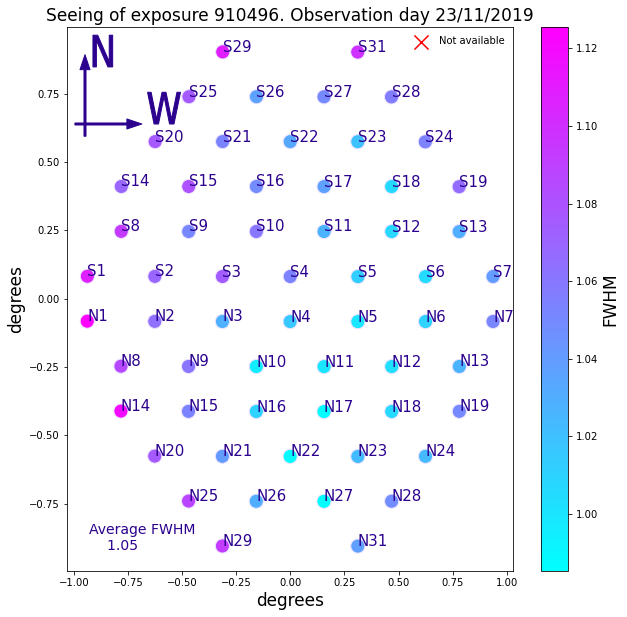

Visit:  910534


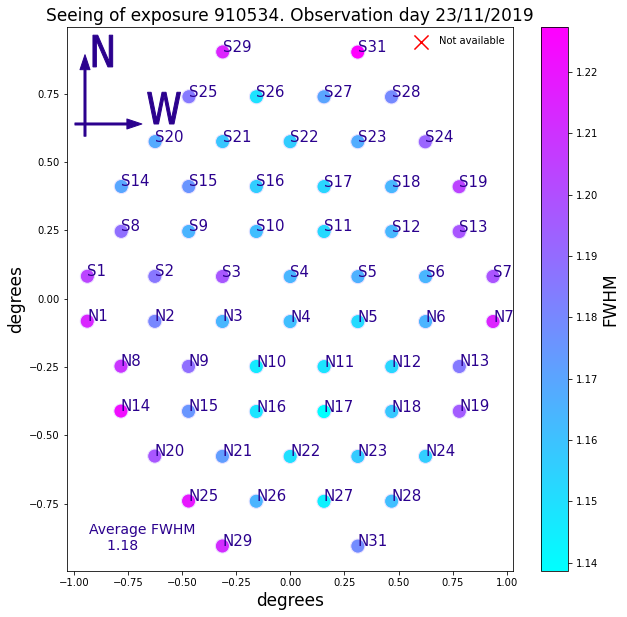

Visit:  910705


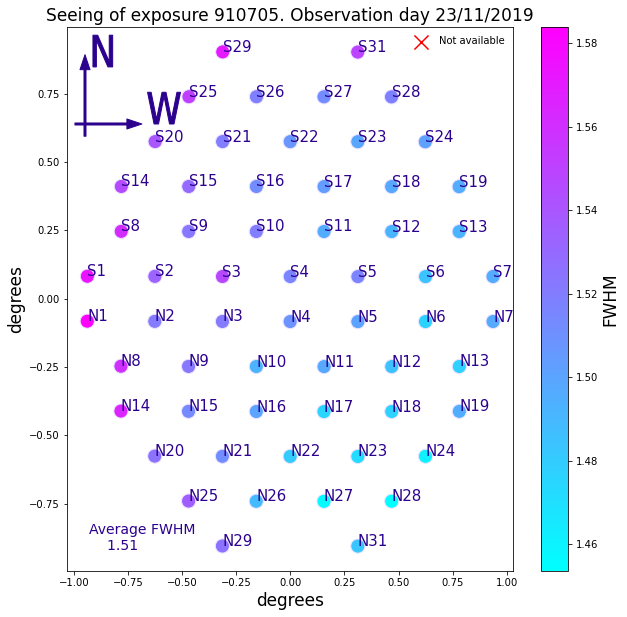

Visit:  910648


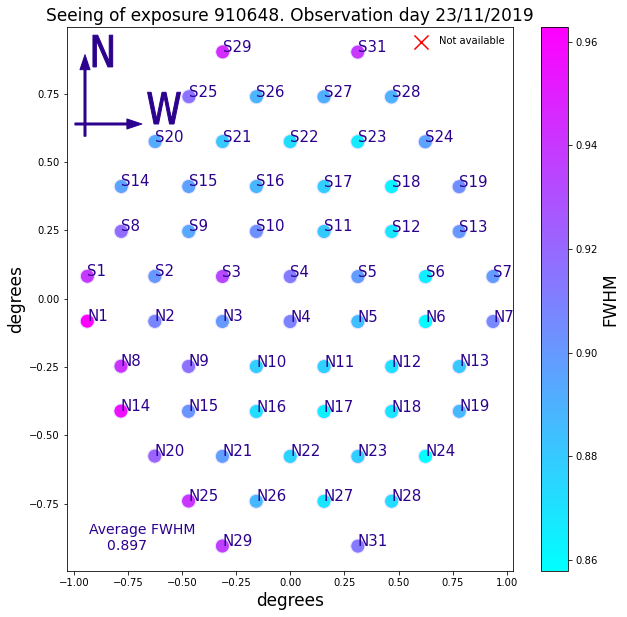

Visit:  910743


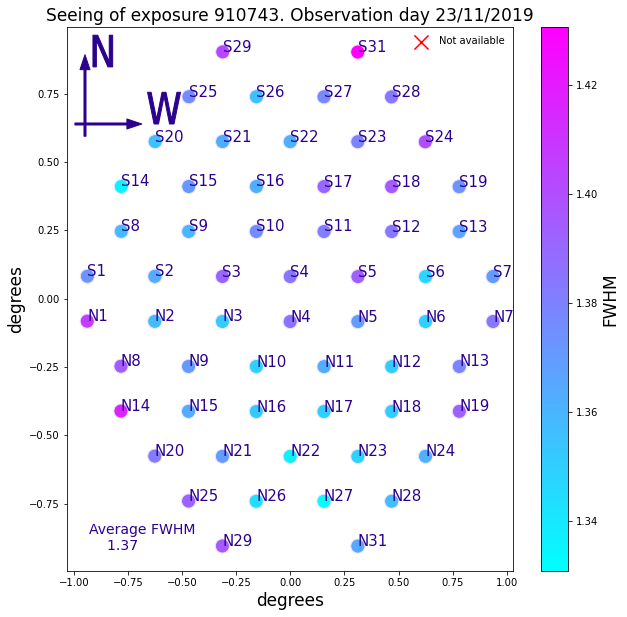

Visit:  910629


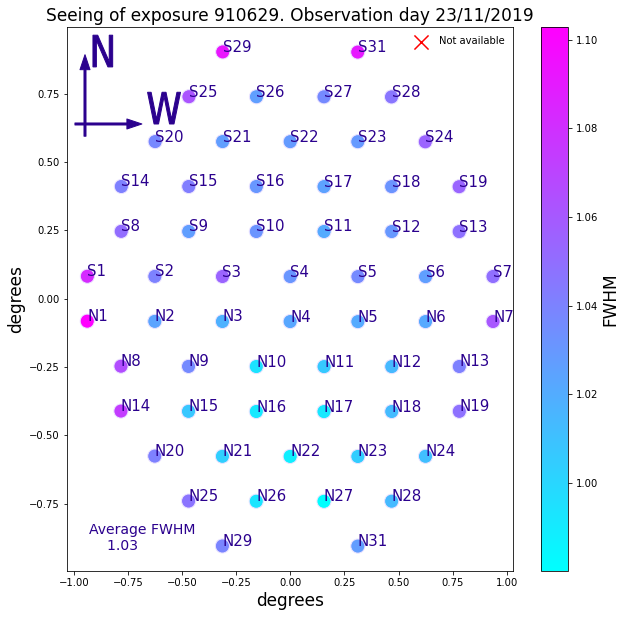

Visit:  910553


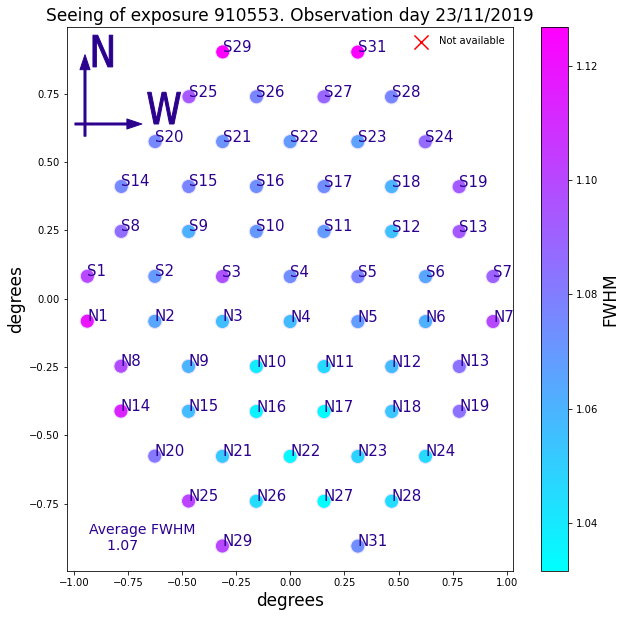

Visit:  910572


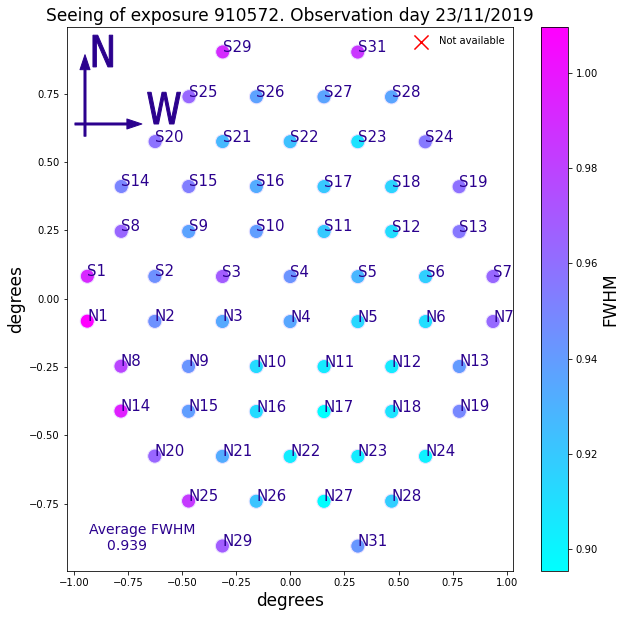

Visit:  910686


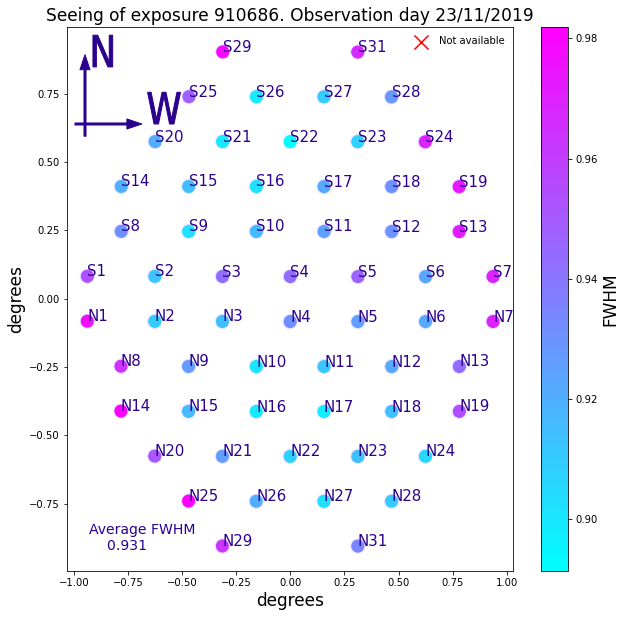

Visit:  910724


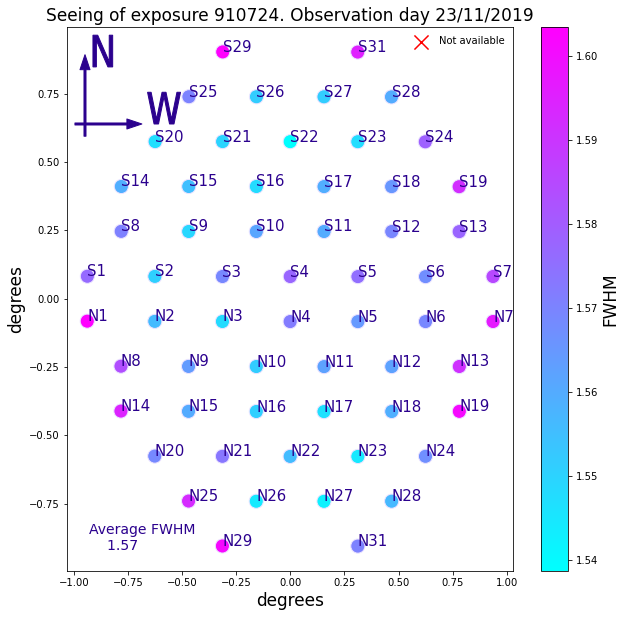

Visit:  910591


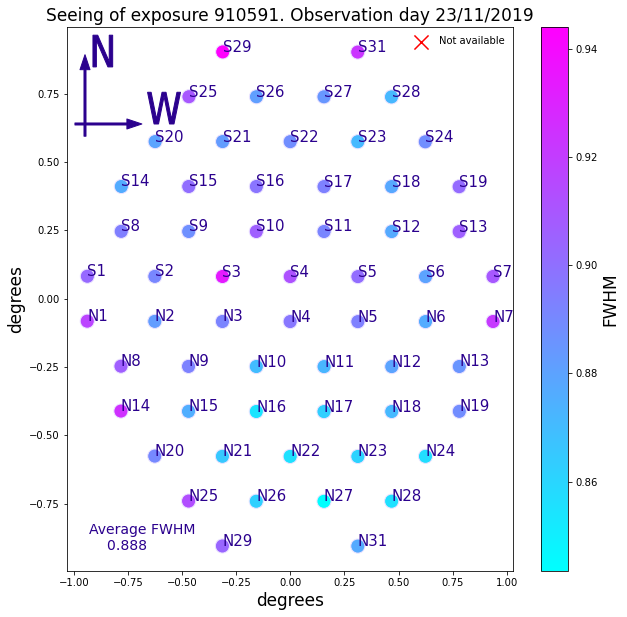

Visit:  910667


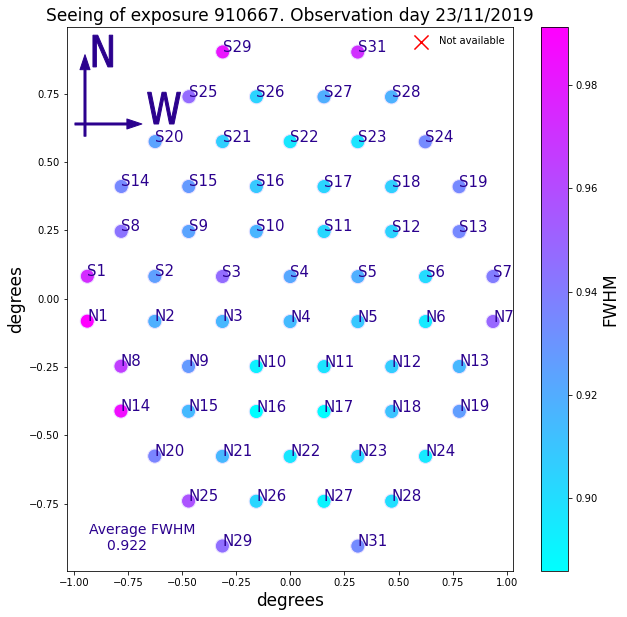

Visit:  910515


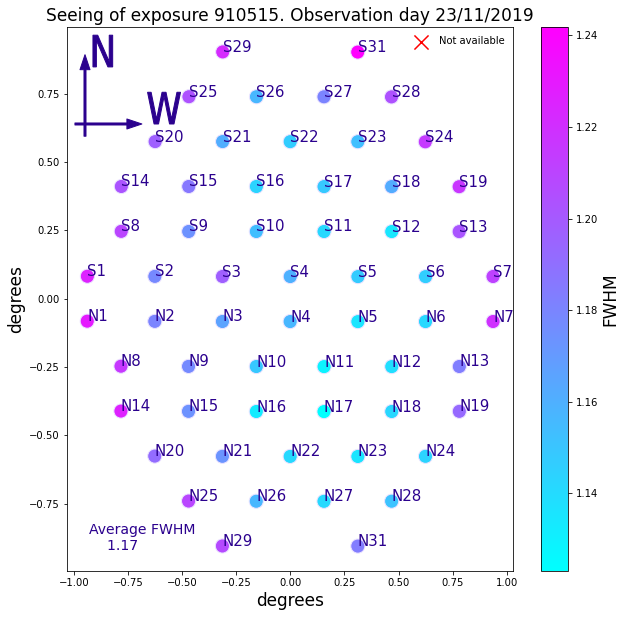

Visit:  910610


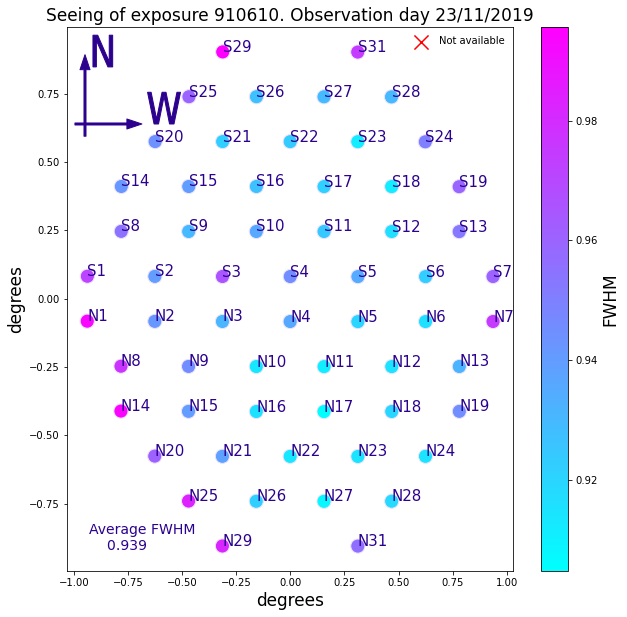

In [9]:
field = "Pointing6"#"Blind15A_25"
collection = 'processCcdOutputs'#{}'.format(field)
visits = data[data['target_name']=='{}'.format(field)].exposure#.iloc[0]]
OD = ObsDay(data[data['target_name']=='{}'.format(field)].day_obs)
avg_seeing = []
for i in range(len(visits)):
    print('Visit: ',visits.iloc[i])
    avg_seeing.append(checkSeeing(collection,visits.iloc[i],OD[i],'calexp', plot=True)[0])


In [47]:
t = QTable([visits, avg_seeing*u.arcsec, OD],
            names=('exposure', 'average seeing', 'Obs. Day'),
            meta={'name': 'first table'})

In [80]:
l = np.array([-1, -1, 1.0511027349179625, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1.1488508458892224, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
j, = np.where(l==-1)
j

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59])

In [50]:
print(t)

exposure average seeing  Obs. Day 
             arcsec               
-------- -------------- ----------
  410914            1.1 17/02/2015
  411054           1.23 17/02/2015
  410970           0.99 17/02/2015
  411020           1.09 17/02/2015
  411354           0.91 18/02/2015
  411405          0.918 18/02/2015
     ...            ...        ...
  411807           1.06 19/02/2015
  411857           1.29 19/02/2015
  412059           1.68 20/02/2015
  412306           2.52 21/02/2015
  412249           1.95 21/02/2015
  742512           1.16 05/05/2018
  742511           1.25 05/05/2018
Length = 19 rows


detector_nomenclature= {'S29':1, 'S30':2, 'S31':3, 'S28':7, 'S27':6, 'S26':5, 'S25':4, 'S24':12, 'S23':11, 'S22':10, 'S21':9, 'S20':8, 'S19':18, 'S18':17, 'S17':16, 'S16':15, 'S15':14, 'S14':13, 'S13':24, 'S12':23, 'S11':22, 'S10':21, 'S9':20,'S8':19, 'S7':31, 'S6':30, 'S5':29, 'S4':28, 'S3':27, 'S2':26, 'S1':25, 'N29':60, 'N30':61, 'N31':62, 'N28':59, 'N27':58, 'N26':57, 'N25':56, 'N24':55, 'N23':54, 'N22':53, 'N21':52, 'N20':51, 'N19':50, 'N18':49, 'N17':48, 'N16':47, 'N15':46, 'N14':45, 'N13':44, 'N12':43, 'N11':42, 'N10':41, 'N9':40,'N8':39, 'N7':38, 'N6':37, 'N5':36, 'N4':35, 'N3':34, 'N2':33, 'N1':32 }
ccds_DECam = np.array([[0., 0., 'S31', 'S30', 'S29', 0., 0.],
       [0., 0., 'S28', 'S27', 'S26', 'S25', 0.],
       [0., 'S24', 'S23', 'S22', 'S21', 'S20', 0.],
       [0., 'S19', 'S18', 'S17', 'S16', 'S15', 'S14'],
       [0., 'S13', 'S12', 'S11', 'S10', 'S9', 'S8'],
       ['S7', 'S6', 'S5', 'S4', 'S3', 'S2', 'S1'],
       ['N7', 'N6', 'N5', 'N4', 'N3', 'N2', 'N1'],
       [0., 'N13', 'N12', 'N11', 'N10', 'N9', 'N8'],
       [0., 'N19', 'N18', 'N17', 'N16', 'N15', 'N14'],
       [0., 'N24', 'N23', 'N22', 'N21', 'N20', 0.],
       [0., 0., 'N28', 'N27', 'N26', 'N25', 0.],
       [0., 0., 'N31', 'N30', 'N29', 0., 0.]])


In [27]:
list(data[(data['target_name']=='Blind15A_25') & (data['day_obs']==20180505)].exposure)
data[(data['target_name']=='Blind15A_25')]
#742019, 742013, 742020, 742014

,exposure,target_name,ra,dec,day_obs
18,410914,Blind15A_25,147.620077,2.162727,20150217
26,411054,Blind15A_25,147.620198,2.162644,20150217
75,410970,Blind15A_25,147.620035,2.162672,20150217
104,411020,Blind15A_25,147.620035,2.162699,20150217
229,411354,Blind15A_25,147.620077,2.162727,20150218
257,411405,Blind15A_25,147.620198,2.163283,20150218
293,411304,Blind15A_25,147.620110,2.162699,20150218
344,411455,Blind15A_25,147.620077,2.162672,20150218
359,411254,Blind15A_25,147.620110,2.162727,20150218
378,411656,Blind15A_25,147.619944,2.162727,20150219


In [23]:
np.transpose(list(data[data['target_name']=='Blind15A_16'].exposure))


array([411011, 410961, 410905, 411446, 411396, 411245, 411295, 411345,
       411647, 411798, 411848, 411697, 411748, 412050, 412297, 412240,
       742493, 742490, 742494, 742489])

blabla

In [9]:
data[data['target_name']=='Blind15A_16'].exposure.iloc[0]

411011